In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split

from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Part 1: Aquire the Data

Inorder to get the data from AWS postgres server we can use this command to connect to the server:
>psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic

psql will ask for password and after we provide it we can use following command to select everything from database table and export it to csv file:
>\COPY (select * from train) to '~/Downloads/train.csv' DELIMITER ',' csv header;

Now that we have our csv file we can move it to an appropriate directory and read it through pandas as usual

In [2]:
titanic_data = pd.read_csv('test.csv')
titanic_data.head(3)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# Part 2: Exploratory Data Analysis

In [3]:
print titanic_data.describe()

            index  PassengerId    Survived      Pclass         Age  \
count  891.000000   891.000000  891.000000  891.000000  714.000000   
mean   445.000000   446.000000    0.383838    2.308642   29.699118   
std    257.353842   257.353842    0.486592    0.836071   14.526497   
min      0.000000     1.000000    0.000000    1.000000    0.420000   
25%    222.500000   223.500000    0.000000    2.000000         NaN   
50%    445.000000   446.000000    0.000000    3.000000         NaN   
75%    667.500000   668.500000    1.000000    3.000000         NaN   
max    890.000000   891.000000    1.000000    3.000000   80.000000   

            SibSp       Parch        Fare  
count  891.000000  891.000000  891.000000  
mean     0.523008    0.381594   32.204208  
std      1.102743    0.806057   49.693429  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    7.910400  
50%      0.000000    0.000000   14.454200  
75%      1.000000    0.000000   31.000000  
max      8.000000

/home/ali/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


In [4]:
df = titanic_data.copy()
df.count()

index          891
PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

As we can see not all data is available and we have multiple values missing from `Age`, `Cabin` and `Embarked` columns. I think removing data rows will have negative effect on our classification since we dont know how the real data would look like.

As our observation first we are going to show survival rate based on sex.

In [5]:
sex_survive = pd.pivot_table(df, index='Sex', values=['index','Survived'], aggfunc=[np.count_nonzero])
sex_survive.columns=['Survived', 'Total']
sex_survive

,Survived,Total
Sex,,
female,233,314
male,109,576


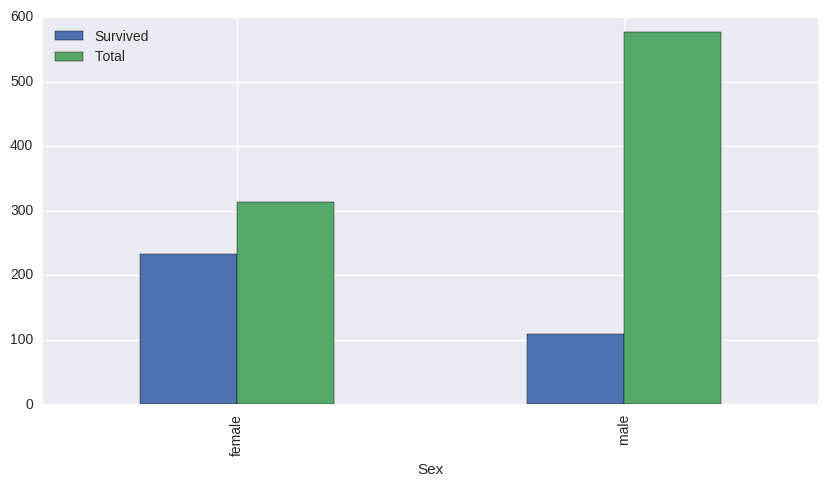

In [6]:
sex_survive.plot(kind='bar', figsize=(10,5))

In [7]:
#Binning:
def binning(col, cut_points, labels=None):
    #Define min and max values:
    minval = col.min()
    maxval = col.max()

    #create list by adding min and max to cut_points
    break_points = [minval] + cut_points + [maxval]

    #if no labels provided, use default labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points)+1)

    #Binning using cut function of pandas
    colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
    return colBin

In [8]:
#Binning age:
cut_points = [12, 40, 50, 199]
labels = ['children', 'young', 'middle_age', 'older', 'no_age']
df["Age_bin"] = binning(df["Age"].fillna(200), cut_points, labels)
# df[df.Age.isnull()].head(5)

In [9]:
age_survive = pd.pivot_table(df, index='Age_bin', values=['index','Survived'], aggfunc=[np.count_nonzero])
age_survive.columns=['Survived', 'Total']
age_survive

,Survived,Total
Age_bin,,
children,40,69
young,195,494
middle_age,33,86
older,22,64
no_age,52,177


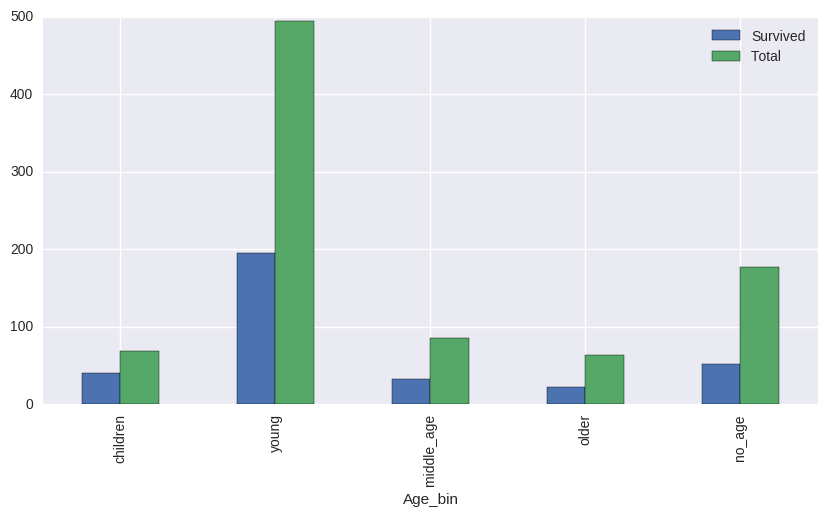

In [10]:
age_survive.plot(kind='bar', figsize=(10,5))

In [11]:
class_survive = pd.pivot_table(df, index='Pclass', values=['index','Survived'], aggfunc=[np.count_nonzero])
class_survive.columns=['Survived', 'Total']
class_survive

,Survived,Total
Pclass,,
1,136,216
2,87,184
3,119,490


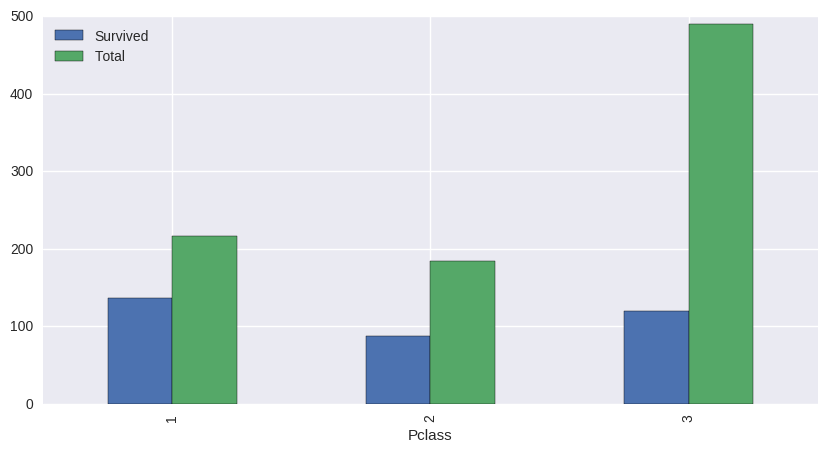

In [12]:
class_survive.plot(kind='bar', figsize=(10,5))

In [13]:
embark_survive = pd.pivot_table(df, index='Embarked', values=['index','Survived'], aggfunc=[np.count_nonzero])
class_survive

,Survived,Total
Pclass,,
1,136,216
2,87,184
3,119,490


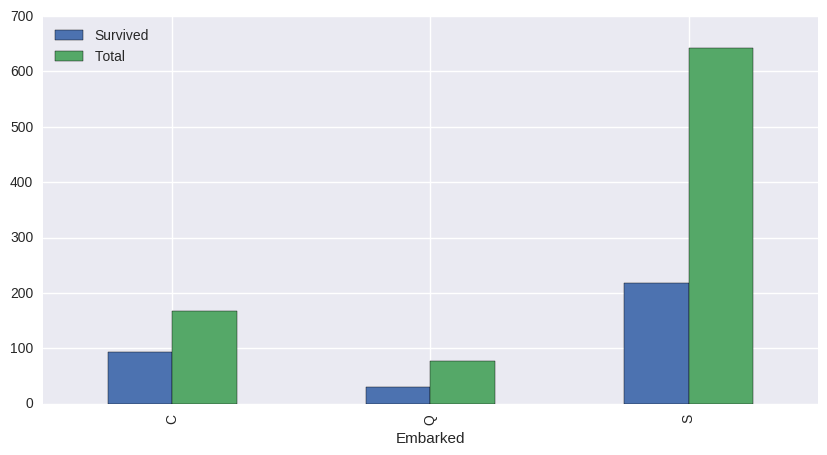

In [14]:
embark_survive.columns=['Survived', 'Total']
embark_survive.plot(kind='bar', figsize=(10,5))

# Part 3: Data Wrangling

In [15]:
decks = titanic_data.Cabin.fillna('0').apply(lambda x: x[0] if x!='0' else None).to_frame()
decks.columns = ['Deck']
decks = pd.get_dummies(decks.Deck, prefix='Deck')
decks.head(3)

,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df.Sex = df.Sex.apply(lambda x: 1 if x=='female' else 0)
df.head(3)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_bin
0,0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,young
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,young
2,2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,young


In [17]:
df["Age_bin"].value_counts()

young         495
no_age        177
middle_age     86
children       69
older          64
Name: Age_bin, dtype: int64

In [18]:
age_bins = pd.get_dummies(df.Age_bin, prefix='Age_bin')
age_bins.head(3)

,Age_bin_children,Age_bin_young,Age_bin_middle_age,Age_bin_older,Age_bin_no_age
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0


In [19]:
pclasses = pd.get_dummies(df.Pclass, prefix='Pclass')
pclasses.head(3)

,Pclass_1,Pclass_2,Pclass_3
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0


In [20]:
embarked = pd.get_dummies(df.Embarked, prefix='Embarked')
embarked.head(3)

,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0


In [21]:
workers = df.Ticket.apply(lambda x: 1 if x=='LINE' else 0).to_frame()
workers.columns = ['Worker']
workers.head(3)

,Worker
0,0
1,0
2,0


In [22]:
singles = df.apply(lambda x: 1 if (x['SibSp']==0 & x['Parch']==0) else 0, axis=1).to_frame()
singles.columns = ['Single']
with_family = df.apply(lambda x: 1 if (x['SibSp']==1 or x['Parch']==1) else 0, axis=1).to_frame()
with_family.columns = ['WithFamily']

# Feature Selection

In [23]:
# def kbest_selector(X, y, k):
#     kbest = SelectKBest(k=k)
#     kbest.fit_transform(X, y)
#     return kbest

# def all_features(X, feature_list):
#     for feat in feature_list:
#         X = X.join(feat, how="left")
#     return X

# def best_features(X, y, method='kbest', cv=6, k=5):
#     if method=='kbest':
#         return SelectKBest(k=k).transform(X)
# #         return kbest_selector(X, y, k)
#     return X

# def knn_score(X, y, n=5, k=5):
#     knn = KNeighborsClassifier(n_neighbors=n)
#     SS = StandardScaler()
#     X = best_features(X, y, k=k, method='kbest')
#     knn.fit(SS.fit_transform(X), y)
#     return knn.score(SS.fit_transform(X), y)

# def best_knn_k(X,y,max_features, n=5):
#     max_score = 0
#     best_k = 0
#     for i in range(max_features):
#         score = knn_score(X, y, k=i+1, n=n)
#         if score > max_score:
#             max_score = score
#             best_k = i+1
#     return best_k

# def rfe_selector(X, y, k=5):
#     model = LogisticRegression()
#     rfe = RFE(estimator=model, step=1, n_features_to_select=k)
#     return rfe.fit_transform(X, y)

# def best_rfe_k(X,y,max_features, n=5):
#     max_score = 0
#     best_k = 0
#     for i in range(max_features):
#         best_feat = rfe_selector(all_features,y, k=i+1)
#         model = LogisticRegression()
#         model.fit(best_feat, y)
#         score = model.score(best_feat, y)
        
#         if score > max_score:
#             max_score = score
#             best_k = i+1
#     return best_k

In [24]:
def combine_features(X, feature_list):
    for feat in feature_list:
        X = X.join(feat, how="left")
    return X

In [25]:
X=df['Sex'].to_frame()
y=df['Survived']
feature_list = [singles, decks, pclasses, age_bins, with_family, embarked, workers]
kbest_selector = SelectKBest(k=5)
all_features = combine_features(X, feature_list)
feature_count = np.count_nonzero(all_features.columns)

# KNN

In [26]:
def knn_score(X, y, n=5):
    knn = KNeighborsClassifier(n_neighbors=n)
    SS = StandardScaler()
    knn.fit(SS.fit_transform(X), y)
    return knn.score(SS.fit_transform(X), y)

def best_knn_k(X,y,max_features, n=5):
    max_score = 0
    best_k = 0
    for i in range(max_features):
        kbest = SelectKBest(k=i+1)
        score = knn_score(kbest.fit_transform(X, y), y, n=n)
        if score > max_score:
            max_score = score
            best_k = i+1
    return best_k

In [94]:
good_features = kbest_selector.fit_transform(all_features, y)

In [95]:
knn = KNeighborsClassifier(n_neighbors=5)
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [96]:
SS = StandardScaler()
knn.fit(SS.fit_transform(good_features), y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [97]:
knn.score(SS.fit_transform(good_features), y)

0.83501683501683499

In [98]:
kbest_selector.k = 18
good_features = kbest_selector.fit_transform(all_features, y)
knn_score(good_features, y, n=5)

0.82491582491582494

In [99]:
print range(feature_count)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [100]:
k = best_knn_k(all_features, y, feature_count)
kbest_selector.k=k
good_features = kbest_selector.fit_transform(all_features, y)
print k
print knn_score(good_features, y, n=5)

11
0.835016835017


In [101]:
model = KNeighborsClassifier()
n_neighbors = [1, 3, 5, 7, 9]
weights = ['uniform', 'distance']
algorithm=['auto', 'ball_tree', 'kd_tree', 'brute']
grid = GridSearchCV(estimator=model, 
                    param_grid={'n_neighbors': n_neighbors,
                                'weights': weights,
                                'algorithm':algorithm
                               },
                    cv = 6
                   )

In [102]:
SS = StandardScaler()
grid.fit(SS.fit_transform(good_features),y)
best_knn_model = grid.best_estimator_
print best_knn_model
print grid.best_score_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.811447811448


In [103]:
x_train, x_test, y_train, y_test = train_test_split(all_features, y)

In [104]:
# good_features = kbest_selector.fit_transform(x_train, y_train)
# SS = StandardScaler()
# grid.fit(SS.fit_transform(good_features),y_train)
# print grid.best_estimator_
# print grid.best_score_

train_knn = kbest_selector.fit_transform(x_train, y_train)
SS = StandardScaler()
best_knn_model.fit(SS.fit_transform(train_knn),y_train)
print best_knn_model.score(SS.fit_transform(train_knn),y_train)

# grid.fit(SS.fit_transform(good_features),y_train)
# print grid.best_estimator_
# print grid.best_score_

0.797904191617


In [106]:
# good_features = kbest_selector.fit_transform(x_test, y_test)
# SS = StandardScaler()
# grid.fit(SS.fit_transform(good_features),y_test)
# print grid.best_estimator_
# print grid.best_score_

test_knn = kbest_selector.fit_transform(x_test, y_test)
SS = StandardScaler()
best_knn_model.fit(SS.fit_transform(test_knn),y_test)
print best_knn_model.score(SS.fit_transform(test_knn),y_test)

0.820627802691


In [45]:
good_features = kbest_selector.fit_transform(all_features, y)
SS = StandardScaler()
grid.fit(SS.fit_transform(good_features),y)
predictions = grid.best_estimator_.predict(SS.fit_transform(good_features))
confusion_matrix(y, predictions)

array([[489,  60],
       [ 87, 255]])

In [46]:
print classification_report(y, predictions)

             precision    recall  f1-score   support

          0       0.85      0.89      0.87       549
          1       0.81      0.75      0.78       342

avg / total       0.83      0.84      0.83       891



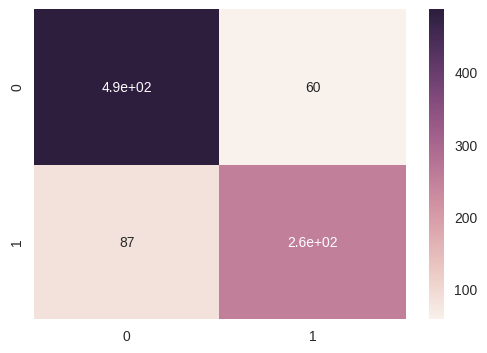

In [47]:
sns.heatmap(confusion_matrix(y, predictions), annot=True)

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

In [49]:
good_features = kbest_selector.fit_transform(x_test, y_test)
SS = StandardScaler()
grid.fit(SS.fit_transform(good_features),y_test)
print grid.best_estimator_
print grid.best_score_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='distance')
0.798206278027


(array([ 0.        ,  0.04477612,  1.        ]), array([ 0.        ,  0.66292135,  1.        ]), array([2, 1, 0]))


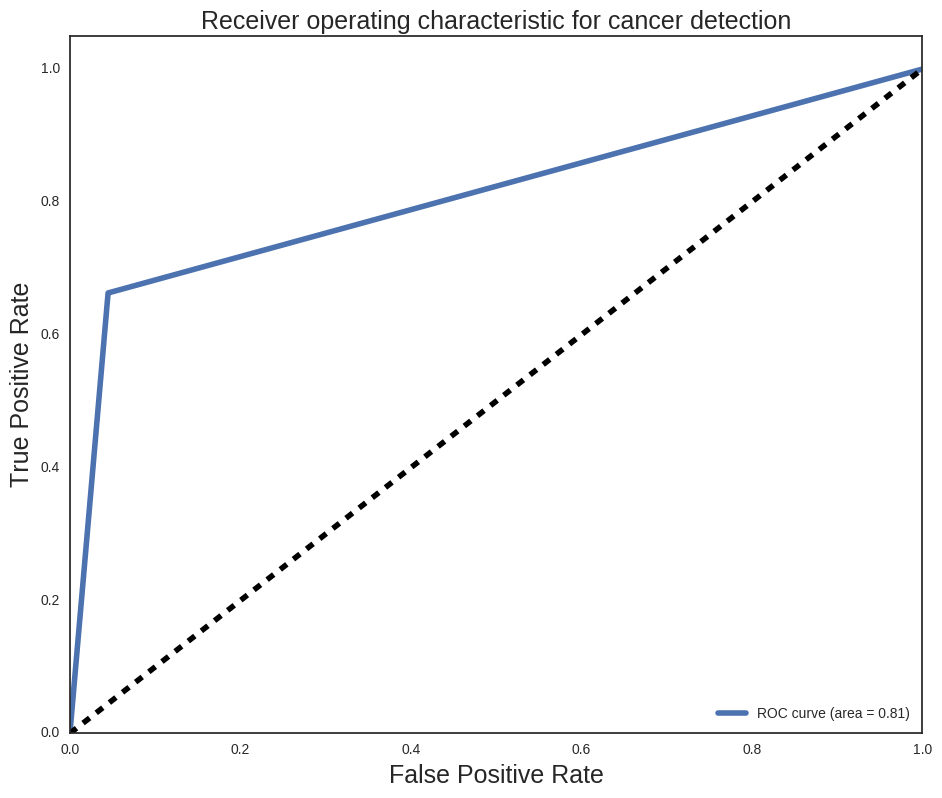

In [50]:
y_pred = grid.best_estimator_.predict(SS.fit_transform(good_features))
FPR = dict()
TPR = dict()
ROC_AUC = dict()
print roc_curve(y_test, y_pred)
FPR[1], TPR[1], _ = roc_curve(y_test, y_pred)
ROC_AUC[1] = auc(FPR[1], TPR[1])
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Logistic Regression

In [51]:
# def rfe_selector(X, y, k=5):
#     model = LogisticRegression()
#     rfe = RFE(estimator=model, step=1, n_features_to_select=k)
#     return rfe.fit_transform(X, y)

def best_log_rfe_k(X,y,model, max_features, n=5):
    max_score = 0
    best_k = 0
    for i in range(max_features):
        rfe = RFE(estimator=model, step=1, n_features_to_select=i+1)
        model.fit(rfe.fit_transform(X, y), y)
        score = model.score(rfe.fit_transform(X, y), y)
        
        if score > max_score:
            max_score = score
            best_k = i+1
    return best_k

In [52]:
def best_log_kbest_k(X,y,model,max_features, n=5):
    max_score = 0
    best_k = 0
    for i in range(max_features):
        kbest = SelectKBest(k=i+1)
        model.fit(kbest.fit_transform(X, y), y)
        score = model.score(kbest.fit_transform(X, y), y)
        if score > max_score:
            max_score = score
            best_k = i+1
    return best_k

In [53]:
# model = LogisticRegression()
# print model.fit(good_features, y)
# print model.score(good_features, y)

In [55]:
rfe_log_model = LogisticRegression()
rfe_k = best_log_rfe_k(all_features, y, rfe_log_model, feature_count)
print rfe_k
rfe_log_selector = RFE(estimator=rfe_log_model, step=1, n_features_to_select=rfe_k)
best_rfe_features = rfe_log_selector.fit_transform(all_features, y)
rfe_log_model.fit(best_rfe_features, y)
print rfe_log_model.score(rfe_log_selector.fit_transform(all_features, y), y)

13
0.821548821549


In [56]:
kbest_log_model = LogisticRegression()
kbest_k = best_log_kbest_k(all_features, y, kbest_log_model, feature_count)
print kbest_k
kbest_log_selector = SelectKBest(k=kbest_k)
best_kbest_features = kbest_log_selector.fit_transform(all_features, y)
kbest_log_model.fit(best_kbest_features, y)
print kbest_log_model.score(kbest_log_selector.fit_transform(all_features, y), y)

23
0.819304152637


In [57]:
log_model_1 = LogisticRegression(penalty='l1', C=0.1)
print log_model_1.fit(best_kbest_features,y)
print log_model_1.score(best_kbest_features,y)
print log_model_1.coef_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.786756453423
[[ 2.10287148  0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.01385403 -0.08364584 -1.35094789
   0.22103976  0.          0.          0.          0.          0.          0.
   0.         -0.54450953  0.        ]]


In [58]:
log_model_2 = LogisticRegression(penalty='l1', C=0.1)
print log_model_2.fit(best_rfe_features,y)
print log_model_2.score(best_rfe_features,y)
print log_model_2.coef_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.786756453423
[[ 2.10303685  0.          0.          0.          0.          0.
   0.09795141 -1.26695554  0.22112563  0.          0.         -0.54396837
   0.        ]]


In [59]:
log_model_3 = LogisticRegression(penalty='l1', C=10)
print log_model_3.fit(best_kbest_features,y)
print log_model_3.score(best_kbest_features,y)
print log_model_3.coef_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.818181818182
[[ 2.6432202   0.60863822  0.58192282  0.73591745  0.28469939  1.1658989
   1.64145895  1.04045095 -0.7426395  -0.76096981  0.         -0.43079969
  -1.62864538  1.26328303  0.         -0.59446368 -1.05099397 -0.18158034
   0.48821596 -0.01540926  0.         -0.61902669  1.36403446]]


LogisticRegression(C=0.03, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.811447811448

Confusion Matrix:
[[523  26]
 [142 200]]

Precision Recall:
             precision    recall  f1-score   support

          0       0.79      0.95      0.86       549
          1       0.88      0.58      0.70       342

avg / total       0.82      0.81      0.80       891



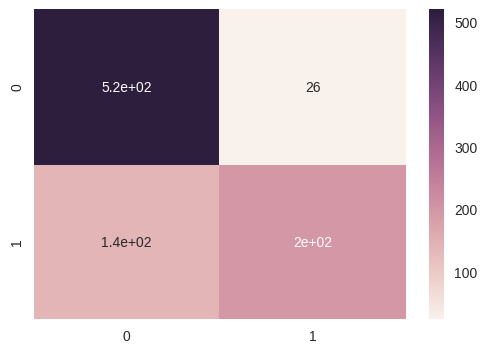

In [60]:
model = LogisticRegression()
Cs = [.01, .03, .05, 0.7, .09, .1, .3, .5, .7, 1, 10, 50, 100]
Ls = ['l1', 'l2']
kbes_grid = GridSearchCV(estimator=model, 
                    param_grid={'C': Cs,
                                'penalty': Ls
                               },
                    cv = 6
                   )
kbes_grid.fit(best_kbest_features,y)
print kbes_grid.best_estimator_
print kbes_grid.best_score_
log_model_kbest = kbes_grid.best_estimator_
predictions = log_model_kbest.predict(best_kbest_features)
print "\nConfusion Matrix:\n", confusion_matrix(y, predictions)
print "\nPrecision Recall:\n", classification_report(y, predictions)
sns.heatmap(confusion_matrix(y, predictions), annot=True)

LogisticRegression(C=0.03, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.811447811448

Confusion Matrix:
[[523  26]
 [142 200]]

Precision Recall:
             precision    recall  f1-score   support

          0       0.79      0.95      0.86       549
          1       0.88      0.58      0.70       342

avg / total       0.82      0.81      0.80       891



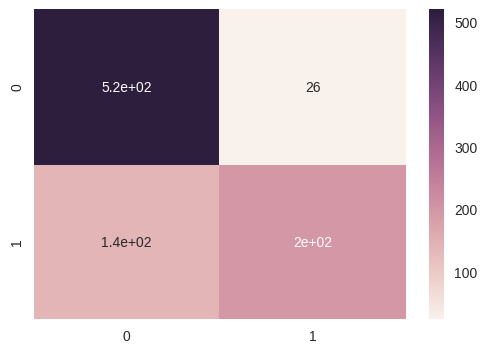

In [61]:
model = LogisticRegression()
Cs = [.01, .03, .05, 0.7, .09, .1, .3, .5, .7, 1, 10, 50, 100]
Ls = ['l1', 'l2']
rfe_grid = GridSearchCV(estimator=model, 
                    param_grid={'C': Cs,
                                'penalty': Ls
                               },
                    cv = 6
                   )
rfe_grid.fit(best_rfe_features,y)
print rfe_grid.best_estimator_
print rfe_grid.best_score_
log_model_rfe = rfe_grid.best_estimator_
predictions = log_model_rfe.predict(best_rfe_features)
print "\nConfusion Matrix:\n", confusion_matrix(y, predictions)
print "\nPrecision Recall:\n", classification_report(y, predictions)
sns.heatmap(confusion_matrix(y, predictions), annot=True)

In [62]:
x_train, x_test, y_train, y_test = train_test_split(all_features, y)

In [63]:
x_train.shape, x_test.shape

((668, 23), (223, 23))

In [64]:
train_kbest = kbest_log_selector.fit_transform(x_train, y_train)
print train_kbest.shape
train_kbest

(668, 23)


array([[ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  1.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  1.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  1.,  0., ...,  0.,  1.,  0.]])

In [65]:
train_rfe = rfe_log_selector.fit_transform(x_train, y_train)
print train_rfe.shape
train_rfe

(668, 13)


array([[ 0.,  0.,  1., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [66]:
# log_reg_with_kbest_train = LogisticRegression()
log_model_kbest.fit(train_kbest, y_train)
print 'Score with training data (kbest):', log_model_kbest.score(train_kbest, y_train)

Score with training data (kbest): 0.823353293413


In [67]:
# log_reg_with_rfe_train = LogisticRegression()
log_model_rfe.fit(train_rfe, y_train)
print 'Score with training data (rfe):', log_model_rfe.score(train_rfe, y_train)

Score with training data (rfe): 0.823353293413


In [68]:
log_reg_with_all_data_train = LogisticRegression()
log_reg_with_all_data_train.fit(x_train, y_train)
print 'Score with training data (all):', log_reg_with_all_data_train.score(x_train, y_train)

Score with training data (all): 0.821856287425


In [69]:
test_kbest = kbest_log_selector.fit_transform(x_test, y_test)
print 'Score with TEST data (kbest):', log_model_kbest.score(test_kbest, y_test)

Score with TEST data (kbest): 0.775784753363


In [70]:
test_rfe = rfe_log_selector.fit_transform(x_test, y_test)
print 'Score with TEST data (rfe):', log_model_rfe.score(test_rfe, y_test)

Score with TEST data (rfe): 0.748878923767


In [71]:
print 'With all of our columns! We get:', log_reg_with_all_data_train.score(x_test, y_test)

With all of our columns! We get: 0.7533632287


(array([ 0.        ,  0.02222222,  0.05925926,  0.12592593,  0.23703704,
        0.40740741,  0.53333333,  1.        ]), array([ 0.13636364,  0.38636364,  0.52272727,  0.54545455,  0.64772727,
        0.82954545,  0.875     ,  1.        ]), array([ 1.06732895,  0.70996413,  0.2549612 ,  0.        , -0.10240362,
       -0.35736482, -0.81236775, -1.16973257]))


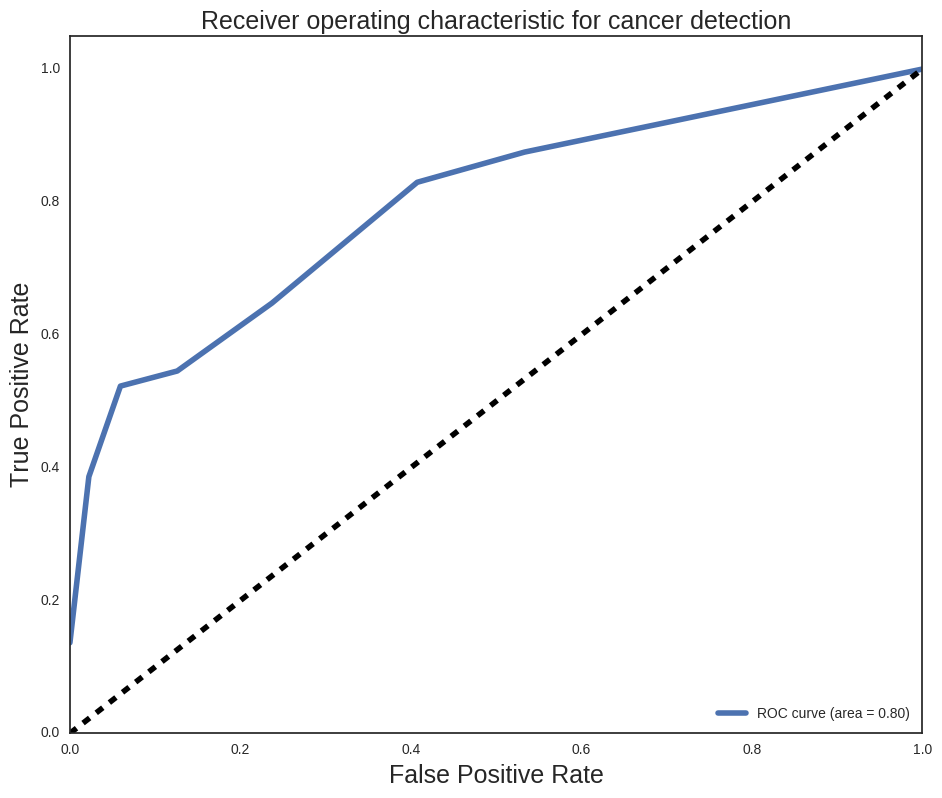

In [72]:
y_score = log_model_kbest.decision_function(kbest_log_selector.fit_transform(x_test, y_test))

FPR = dict()
TPR = dict()
ROC_AUC = dict() # {}

# For class 1, find the area under the curve

print roc_curve(y_test, y_score)

FPR[1], TPR[1], _ = roc_curve(y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])


# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

(array([ 0.        ,  0.14814815,  0.15555556,  0.17037037,  0.8       ,
        0.85185185,  1.        ]), array([ 0.        ,  0.27272727,  0.375     ,  0.625     ,  0.875     ,
        0.89772727,  1.        ]), array([ 2.06733521,  1.06733521,  0.70992287,  0.25498137,  0.        ,
       -0.35741234, -0.81235385]))


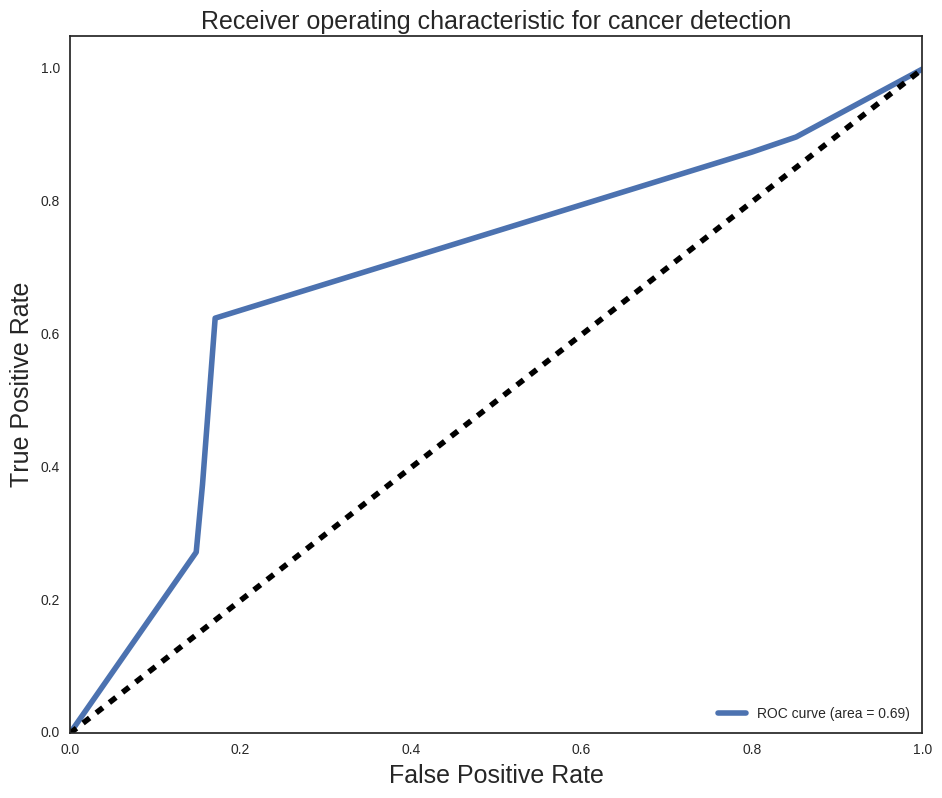

In [73]:
y_score = log_model_rfe.decision_function(rfe_log_selector.fit_transform(x_test, y_test))

FPR = dict()
TPR = dict()
ROC_AUC = dict() # {}

# For class 1, find the area under the curve

print roc_curve(y_test, y_score)

FPR[1], TPR[1], _ = roc_curve(y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])


# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [74]:
print classification_report(y, predictions)

             precision    recall  f1-score   support

          0       0.79      0.95      0.86       549
          1       0.88      0.58      0.70       342

avg / total       0.82      0.81      0.80       891



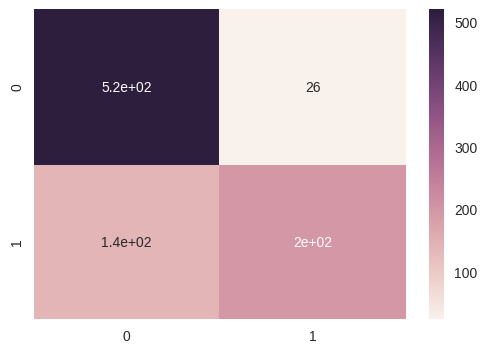

In [75]:
sns.heatmap(confusion_matrix(y, predictions), annot=True)

In [76]:
good_features = kbest_selector.fit_transform(x_test, y_test)
SS = StandardScaler()
grid.fit(SS.fit_transform(good_features),y_test)
print grid.best_estimator_
print grid.best_score_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.780269058296


In [77]:
good_features = kbest_selector.fit_transform(x_test, y_test)
SS = StandardScaler()
grid.fit(SS.fit_transform(good_features),y_test)
print grid.best_estimator_
print grid.best_score_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.780269058296


(array([ 0.        ,  0.08888889,  1.        ]), array([ 0.        ,  0.63636364,  1.        ]), array([2, 1, 0]))


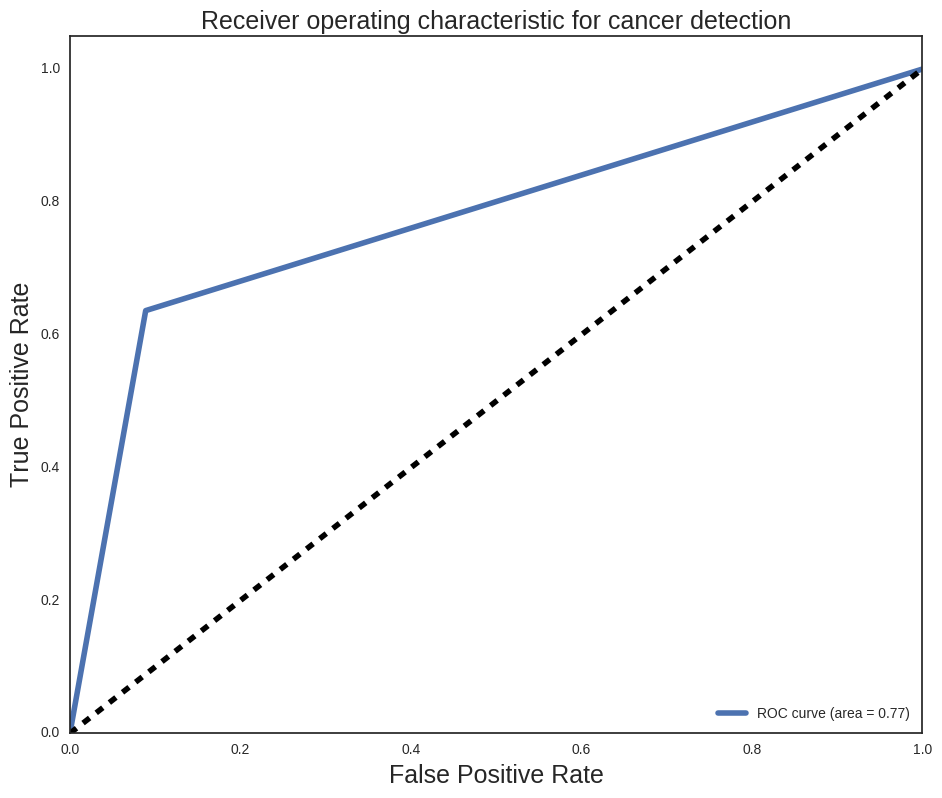

In [78]:
y_pred = grid.best_estimator_.predict(SS.fit_transform(good_features))
FPR = dict()
TPR = dict()
ROC_AUC = dict()
print roc_curve(y_test, y_pred)
FPR[1], TPR[1], _ = roc_curve(y_test, y_pred)
ROC_AUC[1] = auc(FPR[1], TPR[1])
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [79]:
scores = -np.log10(kbest_log_selector.pvalues_)
print scores
print kbest_log_selector.pvalues_

predictors = all_feat.columns

# # Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

[ 12.69158906   1.72525794   0.47630983   0.12099744   0.83439867
   1.43954043   3.0976463    1.21379851   0.11880299          nan
   2.96392324   2.43000114   6.42280747   2.71493583   1.19652282
   0.01548086   0.29164308   0.05693037   3.24900783   0.28251857
   1.06353749   1.16130616   0.37604336]
[  2.03428096e-13   1.88253068e-02   3.33956710e-01   7.56837359e-01
   1.46420314e-01   3.63462471e-02   7.98644866e-04   6.11225530e-02
   7.60671269e-01              nan   1.08661766e-03   3.71534251e-03
   3.77739611e-07   1.92780976e-03   6.36029390e-02   9.64981837e-01
   5.10924726e-01   8.77141450e-01   5.63627490e-04   5.21772793e-01
   8.63898086e-02   6.89753389e-02   4.20684629e-01]


NameError: name 'all_feat' is not defined

In [ ]:
scores = rfe_log_selector.ranking_
print scores
predictors = all_feat.columns
print rfe_log_selector.support_
# for item in zip(predictors, scores, rfe_log_selector.support_):
#     print item
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()